# Data Processing
To combine all data sets into a single dataframe

In [13]:
# import libraries
import pandas as pd
import glob

demand_vic = glob.glob("/Users/jiehni/monash/ads1002/project/Demand/*_VIC*.csv")
demand_vic.sort()

df_list = [pd.read_csv(f) for f in demand_vic]
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(combined_df.head())
else:
    print("No CSV files were loaded.")

Files found: ['/Users/jiehni/monash/ads1002/project/Demand/DATA200001_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200002_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200003_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200004_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200005_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200006_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200007_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200008_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200009_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200010_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200011_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200012_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200101_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DATA200102_VIC1.csv', '/Users/jiehni/monash/ads1002/project/Demand/DAT

In [14]:
# parse the SETTLEMENTDATE column to datetime
combined_df['SETTLEMENTDATE'] = pd.to_datetime(combined_df['SETTLEMENTDATE'], errors='coerce')

# drop any rows where the datetime is NaT
combined_df.dropna(subset=['SETTLEMENTDATE'], inplace=True)

# sort by time (optional but good practice)
combined_df.sort_values(by='SETTLEMENTDATE', inplace=True)

# set datetime as index (makes merging and plotting easier)
combined_df.set_index('SETTLEMENTDATE', inplace=True)

# keep only necessary columns
demand_df = combined_df[['TOTALDEMAND']].copy()


In [18]:
weather_df = pd.read_csv(
    "/Users/jiehni/monash/ads1002/project/temperature/HM01X_Data_086071_999999999743964.txt",
    low_memory=False
)

print(weather_df.columns)

weather_df['Datetime'] = pd.to_datetime({
    'year': weather_df['Year Month Day Hour Minutes in YYYY'],
    'month': weather_df['MM'],
    'day': weather_df['DD'],
    'hour': weather_df['HH24'],
    'minute': weather_df['MI format in Local time']
}, errors='coerce')

# Drop invalid datetime rows
weather_df = weather_df.dropna(subset=['Datetime'])
weather_df = weather_df.set_index('Datetime')

Index(['hm', 'Station Number', 'Year Month Day Hour Minutes in YYYY', 'MM',
       'DD', 'HH24', 'MI format in Local time',
       'Year Month Day Hour Minutes in YYYY.1', 'MM.1', 'DD.1', 'HH24.1',
       'MI format in Local standard time',
       'Precipitation since 9am local time in mm',
       'Quality of precipitation since 9am local time',
       'Air Temperature in degrees C', 'Quality of air temperature',
       'Wet bulb temperature in degrees C', 'Quality of Wet bulb temperature',
       'Dew point temperature in degrees C',
       'Quality of dew point temperature', 'Relative humidity in percentage %',
       'Quality of relative humidity', 'Wind speed in km/h',
       'Wind speed quality', 'Wind direction in degrees true',
       'Wind direction quality',
       'Speed of maximum windgust in last 10 minutes in  km/h',
       'Quality of speed of maximum windgust in last 10 minutes',
       'Mean sea level pressure in hPa', 'Quality of mean sea level pressure',
       'Stati

In [20]:
# Select temperature column and rename
weather_clean = weather_df[['Air Temperature in degrees C']].copy()
weather_clean.columns = ['Temperature']
weather_clean['Temperature'] = pd.to_numeric(weather_clean['Temperature'], errors='coerce')


# Interpolate missing values
weather_clean = weather_clean.interpolate(method='time').dropna()

In [21]:
merged_df = pd.merge(
    demand_df,
    weather_clean,
    left_index=True,
    right_index=True,
    how='inner'
)

print(merged_df.head())


                     TOTALDEMAND  Temperature
SETTLEMENTDATE                               
2000-01-01 01:30:00   4599.70167         13.7
2000-01-01 02:00:00   4478.99000         13.6
2000-01-01 02:30:00   4228.81000         13.3
2000-01-01 03:00:00   3989.10000         14.1
2000-01-01 03:30:00   3783.93167         13.5


In [23]:
from scipy.stats import linregress

slope, intercept, r, p, se = linregress(merged_df['Temperature'], merged_df['TOTALDEMAND'])
print(f"Slope: {slope:.2f}, R²: {r**2:.3f}")


Slope: 12.57, R²: 0.010


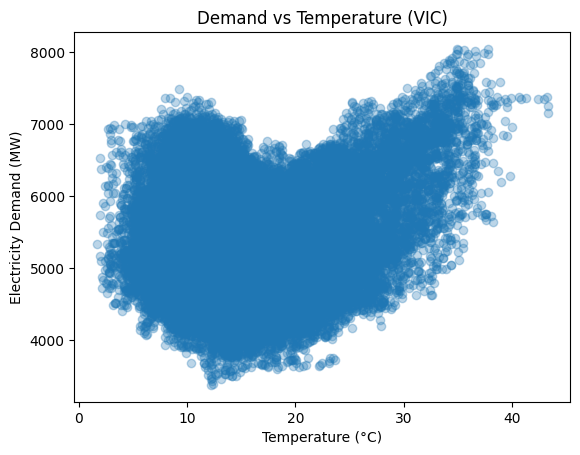

In [24]:
import matplotlib.pyplot as plt

plt.scatter(merged_df['Temperature'], merged_df['TOTALDEMAND'], alpha=0.3)
plt.title('Demand vs Temperature (VIC)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Demand (MW)')
plt.show()
